In [1]:
import pickle
import shutil

import numpy as np
import matplotlib.pyplot as plt

# from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import os
import glob

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

%load_ext autoreload
%autoreload 2

## Load pulsars and PTA object

In [2]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J1614-2230
J1730-2304
J1910+1256
J1630+3734
J1705-1903


In [3]:
# load injected parameters
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
x_inj_dict = data_dict['x_inj'].item()

In [4]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1614-2230_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1614-2230_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1614-2230_red_noise                     FourierBasisGP                 2                   

params:
J1614-2230_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1614-2230_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
J1614-2230_cw                            CWSignal                       10                  

params:
cw_cost

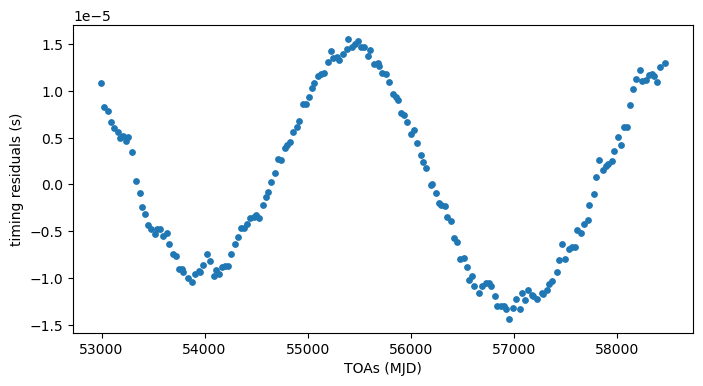

In [5]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [6]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [7]:
# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# prior function
def get_lnprior(params):
    return pta.get_lnprior(get_dict(params))

# posterior
def get_lnpost(params):
    return get_lnprior(params) + get_lnlike(params)

In [8]:
x_test = np.array([param.sample() for param in pta.params])
print(get_lnpost(x_test))

-52102.47179856877


In [9]:
%timeit get_lnpost(x_test)

927 μs ± 46.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# store injected parameters in array
x_inj = []
for param_name in pta.param_names:
    print(f'{param_name} = {x_inj_dict[param_name]}')
    if param_name[-6:] == 'p_dist':  # pulsar distances are normalized
        x_inj.append(0.)
    else:
        x_inj.append(x_inj_dict[param_name])
x_inj = np.array(x_inj)

J1614-2230_cw_p_dist = 1.0
J1614-2230_cw_p_phase = 1.9176677666709026
J1614-2230_red_noise_gamma = 4.6
J1614-2230_red_noise_log10_A = -13.6
J1630+3734_cw_p_dist = 1.0
J1630+3734_cw_p_phase = 2.0784810248722074
J1630+3734_red_noise_gamma = 4.6
J1630+3734_red_noise_log10_A = -14.2
J1705-1903_cw_p_dist = 1.0
J1705-1903_cw_p_phase = 0.8264899725683534
J1705-1903_red_noise_gamma = 3.1
J1705-1903_red_noise_log10_A = -13.7
J1730-2304_cw_p_dist = 0.51
J1730-2304_cw_p_phase = 2.862027391824693
J1730-2304_red_noise_gamma = 2.8
J1730-2304_red_noise_log10_A = -13.8
J1910+1256_cw_p_dist = 1.95
J1910+1256_cw_p_phase = 2.9118116520323447
J1910+1256_red_noise_gamma = 3.5
J1910+1256_red_noise_log10_A = -14.1
cw_cosinc = 6.123233995736766e-17
cw_costheta = 6.123233995736766e-17
cw_log10_Mc = 9.0
cw_log10_dL = -0.09691001300805639
cw_log10_fgw = -8.397940008672037
cw_phase0 = 3.141592653589793
cw_phi = 4.39822971502571
cw_psi = 1.5707963267948966


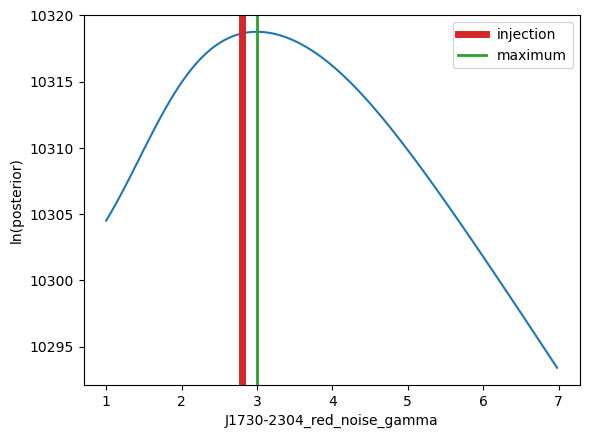

In [15]:
# plot cross-sections of posterior
param_ndx = 14
num_evals = 100
# get "minimum" and "maximum" of parameter values
param_samples = np.array([pta.params[param_ndx].sample() for _ in range(1000)])
param_vals = np.linspace(np.min(param_samples), np.max(param_samples), num_evals)
x_vals = np.tile(x_inj, (num_evals, 1))
x_vals[:, param_ndx] = param_vals
lnposts = np.array([get_lnpost(x) for x in x_vals])
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='C3', label='injection', lw=5)
plt.axvline(param_vals[np.argmax(lnposts)], color='C2', label='maximum', lw=2)
plt.legend()
plt.xlabel(pta.param_names[param_ndx])
plt.ylabel('ln(posterior)')
plt.show()

## MCMC

In [12]:
# # set up the sampler:
# ndim = len(x_inj)
# cov = np.eye(ndim) * 10.0
# cov[-4] = 0.0001
# outDir = 'enterprise_chains'

# sampler = ptmcmc(ndim=ndim,
#                  logl=get_lnlike,
#                  logp=get_lnprior,
#                  cov=cov, 
#                  outDir=outDir,
#                  resume=False)

# # do MCMC
# num_samples = int(2e6)
# sampler.sample(p0=x_inj,
#                # p0=np.array([param.sample() for param in pta.params]),
#                Niter=num_samples,
#                # ladder=1.2**np.arange(20),
#                # hotChain=True,
#             #    SCAMweight=50,
#             #    AMweight=15,
#             #    DEweight=50,
#                # thin=1,
#                )

# # store chains in compressed binary format
# print('Loading chains.')
# chains = np.loadtxt('enterprise_chains/chain_1.txt', skiprows=int(0), usecols=(range(ndim + 1)))
# ent_samples_dict = {name: val for name, val in zip(pta.param_names, chains[:,:-1].T)}
# ent_samples_dict['lnposts'] = chains[:,-1]
# # np.savez_compressed('ent_samples_dict.npz', **ent_samples_dict)
# np.savez_compressed(
#     'ent_samples_dict.npz',
#     **{k: v[:] for k, v in ent_samples_dict.items()}
# )
# shutil.rmtree('enterprise_chains')
# print('MCMC samples saved.')

In [131]:
folder = 'enterprise_chains'

# Find all files matching chain_*.txt
files = glob.glob(os.path.join(folder, "chain_*.txt"))

# Extract temperatures from filenames
def get_temp(fname):
    base = os.path.basename(fname)
    temp_str = base.replace("chain_", "").replace(".txt", "")
    return float(temp_str)

# load chains
files_sorted = sorted(files, key=get_temp)
chains = [np.loadtxt(f) for f in files_sorted]
ladder = [get_temp(f) for f in files_sorted]

# make pandas data frame for each chain
dfs = []
lnlikes = []
for chain, temp in zip(chains, ladder):
    dfs.append(pd.DataFrame(chain[:, :len(pta.param_names)], columns=pta.param_names))
    lnlikes.append(chain[:, -3])

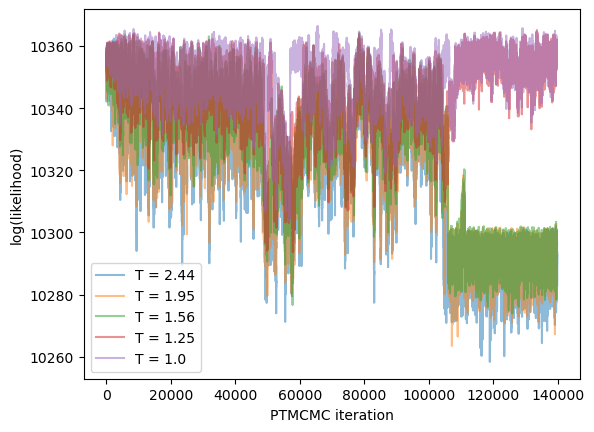

In [132]:
_ = [plt.plot(lnlike, color=f'C{i}', label=f'T = {temp}', alpha=0.5)
     for i, (lnlike, temp) in enumerate(zip(lnlikes[::-1], ladder[::-1]))]
plt.xlabel('PTMCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend()
plt.show()

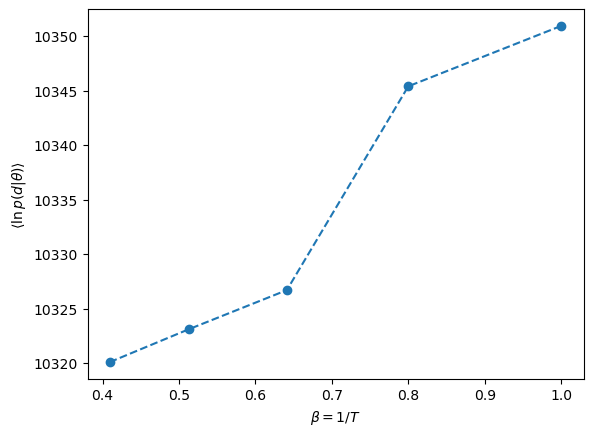

In [133]:
# illustrate thermodynamic integration
burnin = 10_000
betas = 1. / np.array(ladder)
plt.plot(betas, [np.mean(lnlike[burnin:], axis=0)
                 for lnlike in lnlikes], ls='--', marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle \ln p(d | \theta) \rangle$')
plt.show()

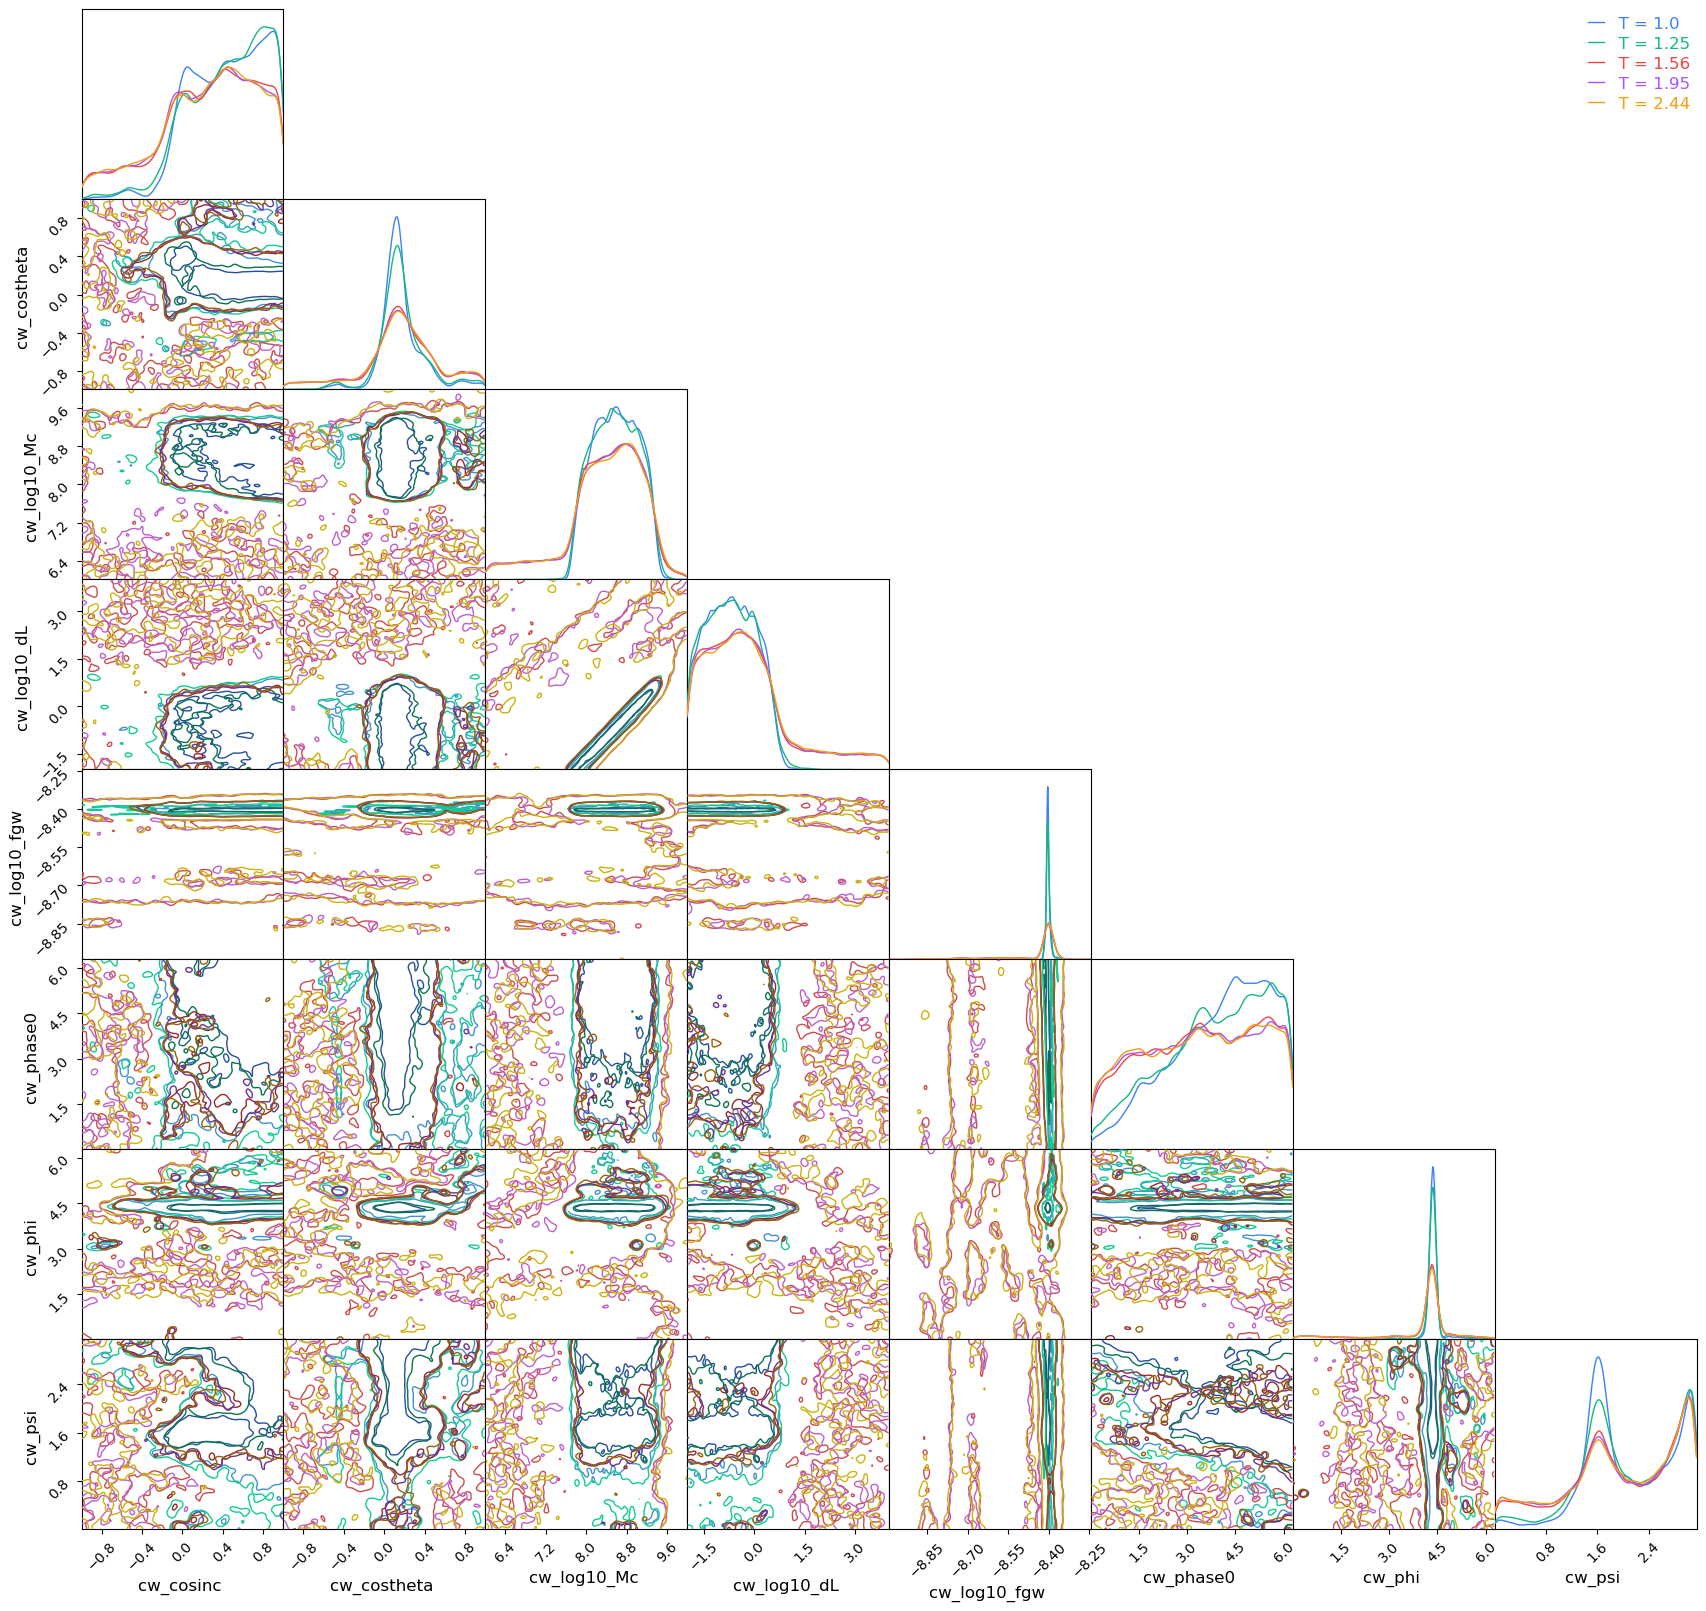

In [136]:
param_ndxs = np.r_[-8:0]
c = ChainConsumer()
for df, temp in zip(dfs, ladder):
    c.add_chain(Chain(samples=df.iloc[burnin:, param_ndxs], name=f'T = {temp}'))
fig = c.plotter.plot()

In [137]:
# save data frame for T = 1 chain
dfs[0].iloc[burnin:].to_pickle("ent_df.pkl.gz", compression="gzip")